**Recopiez ce notebook et envoyez-moi le lien à la fin de la séance.**

Votre **nom**: NGUYEN


Votre **prénom**: Tai

Votre **Nombre etudiant**: 12108339


*Observations/commentaires éventuels de l'étudiant à l'enseignant*:




# Neural Networks

*Emmanuel Viennet, 2019-12-15, 2022-01-11*

## Application to digit images recognition


Neural networks can be constructed using the ``torch.nn`` package.

Now that you had a glimpse of ``autograd``, ``nn`` depends on
``autograd`` to define models and differentiate them.
An ``nn.Module`` contains layers, and a method ``forward(input)`` that
returns the ``output``.


A typical training procedure for a neural network is as follows:

- Define the neural network that has some learnable parameters (or
  weights)
- Iterate over a dataset of inputs
- Process input through the network
- Compute the loss (how far is the output from being correct)
- Propagate gradients back into the network’s parameters
- Update the weights of the network, typically using a simple update rule:
  ``weight = weight - learning_rate * gradient``





In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat # SciPy module that loads mat-files

# Define the neural network


Let’s define a fully connected neural network with one hidden layer:

In [127]:
import torch
import torch.nn as nn
import torch.nn.functional as F

ImWidth  = 28 # input image size
ImHeight = 28
N1 = 100 # neurons on first hidden layer
NbClass= 10 # neurons on output layer

class Net(nn.Module):

    def __init__(self, ovf = False, p = 0.1):
        super(Net, self).__init__()        
        self.fc1 = nn.Linear(ImWidth*ImHeight, N1)
        self.fc2 = nn.Linear(N1, NbClass)  
        self.dropout = nn.Dropout(p=p)
        ## add ovf as the flag to avoid overfitting
        self.ovf = ovf
    def forward(self, x):
        if self.ovf:
            x = torch.flatten(x, 1) # the input is a 2d image        
            x = F.relu(self.fc1(x))
            x = torch.sigmoid(self.fc2(x))
        else:
            x = torch.flatten(x, 1) # the input is a 2d image        
            x = F.relu(self.dropout(self.fc1(x)))
            x = torch.sigmoid(self.dropout(self.fc2(x)))
        return x

net = Net()
print(net)

Net(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)


## Explanations and experiments

Before learning this network, let's experiment a bit with PyTorch.

You just have to define the ``forward`` function, and the ``backward``
function (where gradients are computed) is automatically defined for you
using ``autograd``.
You can use any of the Tensor operations in the ``forward`` function.

The learnable parameters of a model are returned by ``net.parameters()``



In [3]:
params = list(net.parameters())
print("network parameters:")
for i in range(len(params)):
    print('params[{}] size={}'.format(i, params[i].size()))

network parameters:
params[0] size=torch.Size([100, 784])
params[1] size=torch.Size([100])
params[2] size=torch.Size([10, 100])
params[3] size=torch.Size([10])


**Question**: can you interpret these parameters sizes ? (what is `params[1]` ?) 

**Answer**: 
* The `params[0]` is the **weight** of hidden layer 1
* The `params[1]` is the **bias** of hidden layer 1.
* The `params[2]` is the **weight** of hidden layer 2.
* The `params[3]` is the **bias** of hidden layer 2.

### Let try a random 28x28 input:

In [7]:
input = torch.randn(1, ImWidth, ImHeight)
out = net(input)
print(out)

tensor([[0.4478, 0.4972, 0.5293, 0.4916, 0.4279, 0.5986, 0.5259, 0.5695, 0.5293,
         0.4330]], grad_fn=<SigmoidBackward>)


**Question**: what is the dimension of the output (printed above) ? What is the class associated by our untrained network to this random input image ?

**Answer**: the dimension of the output according to the number of classes (10 classes from 0 to 9). This output belongs to `5` because the value of the 5th element in the output array is maximum.

### Zero the gradient buffers of all parameters and backprops with random gradients:



In [8]:
net.zero_grad()
out.backward(torch.randn(1, 10))

<div class="alert alert-info"><h4>Note</h4><p>``torch.nn`` only supports mini-batches. The entire ``torch.nn``
    package only supports inputs that are a mini-batch of samples, and not
    a single sample.

    For example, ``nn.Conv2d`` will take in a 4D Tensor of
    ``nSamples x nChannels x Height x Width``.

    If you have a single sample, just use ``input.unsqueeze(0)`` to add
    a fake batch dimension.

Before proceeding further, let's recap all the classes you’ve seen so far.

**Recap:**
  -  ``torch.Tensor`` - A *multi-dimensional array* with support for autograd
     operations like ``backward()``. Also *holds the gradient* w.r.t. the
     tensor.
  -  ``nn.Module`` - Neural network module. *Convenient way of
     encapsulating parameters*, with helpers for moving them to GPU,
     exporting, loading, etc.
  -  ``nn.Parameter`` - A kind of Tensor, that is *automatically
     registered as a parameter when assigned as an attribute to a*
     ``Module``.
  -  ``autograd.Function`` - Implements *forward and backward definitions
     of an autograd operation*. Every ``Tensor`` operation creates at
     least a single ``Function`` node that connects to functions that
     created a ``Tensor`` and *encodes its history*.

**At this point, we covered:**
  -  Defining a neural network
  -  Processing inputs and calling backward

**Still Left:**
  -  Computing the loss
  -  Updating the weights of the network

Loss Function
-------------
A loss function takes the (output, target) pair of inputs, and computes a
value that estimates how far away the output is from the target.

There are several different
loss functions https://pytorch.org/docs/nn.html#loss-functions under the
nn package .
A simple loss is: ``nn.MSELoss`` which computes the mean-squared error
between the input and the target.

For example:

</div>

In [9]:
output = net(input)
target = torch.randn(10)  # a dummy target, for example
target = target.view(1, -1)  # make it the same shape as output
print(target)
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)

tensor([[ 0.7463,  1.3176, -1.0595,  0.4351, -1.3405,  0.9161,  0.6735, -1.6556,
          0.8974,  1.2186]])
tensor(1.2244, grad_fn=<MseLossBackward>)


As you can see, the loss is a tensor, which allows PyTorch (autograd) to automatically compute its gradient.

### Gradient backpropagation

To backpropagate the error all we have to do is to ``loss.backward()``.
You need to clear the existing gradients though, else gradients will be
accumulated to existing gradients.


Now we shall call ``loss.backward()``, and have a look at fc1's bias
gradients before and after the backward.



In [10]:
net.zero_grad()     # zeroes the gradient buffers of all parameters

print('fc1.bias.grad before backward')
print(net.fc1.bias.grad)

loss.backward()

print('fc1.bias.grad after backward')
print(net.fc1.bias.grad)

fc1.bias.grad before backward
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
fc1.bias.grad after backward
tensor([-0.0117,  0.0000,  0.0000,  0.0000,  0.0000, -0.0067, -0.0075,  0.0122,
         0.0000,  0.0000,  0.0164,  0.0000,  0.0000, -0.0087, -0.0159,  0.0000,
        -0.0122,  0.0000,  0.0000,  0.0000,  0.0135,  0.0000, -0.0132, -0.0019,
        -0.0046, -0.0034,  0.0000,  0.0000,  0.0000,  0.0019,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0171,  0.0099,  0.0000, -0.0100,  0.0000,  0.0000,
         0.0056,  0.0111,  0.0000,  0.0000,  0.0029,  0.0000,  0.0000,  0.0031,
         0.0000,  0.

Now, we have seen how to use loss functions.

**Read Later:**

  The neural network package contains various modules and loss functions
  that form the building blocks of deep neural networks. A full list with
  documentation is here https://pytorch.org/docs/nn.

**The only thing left to learn is:**

  - Updating the weights of the network

Update the weights
------------------
The simplest update rule used in practice is the Stochastic Gradient
Descent (SGD):

     ``weight = weight - learning_rate * gradient``

We can implement this using simple python code:

.. code:: python

    learning_rate = 0.01
    for f in net.parameters():
        f.data.sub_(f.grad.data * learning_rate)

However, as you use neural networks, you want to use various different
update rules such as SGD, Nesterov-SGD, Adam, RMSProp, etc.
To enable this, we built a small package: ``torch.optim`` that
implements all these methods. Using it is very simple:



In [11]:
import torch.optim as optim

# create your optimizer
optimizer = optim.SGD(net.parameters(), lr=1) # learning_rate = 1.0

# in your training loop:
optimizer.zero_grad()   # zero the gradient buffers
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step()    # Does the update

Observe how gradient buffers had to be manually set to zero using
``optimizer.zero_grad()``. This is because gradients are accumulated
as explained before.



# Experiment on MNIST digits

Our network retina is 28x28

## Load and prepare data

La cellule suivante permet de lire des données depuis votre Google Drive: il vous faut adapter le chemin pour indiquer le dossier dans lequel vous aurez placé vos données. Lors de la première exécution, vous devrez autoriser ce code à accéder à votre drive.

In [10]:
# from google.colab import drive

# drive.mount('/content/drive')
# # On peut utiliser !ls pour explorer son drive...
# # ! ls 

Mounted at /content/drive


In [12]:
import os

# Le fichier des données (images des chiffres) est à récupérer ici
# https://drive.google.com/file/d/1L9JhlevAsKlOGZImjY4b6ny4_GX_ZyUv/view?usp=sharing
# et à placer dans VOTRE drive pour l'utiliser.
# Ajuster le chemin ci-dessous pour le retrouver !
mnist_raw = loadmat('./mnist-original.mat')
print(mnist_raw)

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Sun Mar 30 03:19:02 2014', '__version__': '1.0', '__globals__': [], 'mldata_descr_ordering': array([[array(['label'], dtype='<U5'), array(['data'], dtype='<U4')]],
      dtype=object), 'data': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), 'label': array([[0., 0., 0., ..., 9., 9., 9.]])}


In [13]:
data = torch.from_numpy(mnist_raw['data'].transpose()).view((-1,1,ImWidth,ImHeight))
print(data.shape) # 70000 28x28 images
label = mnist_raw['label'].reshape(-1).astype(int)
print(label.shape)
print(label[50000:50010])

torch.Size([70000, 1, 28, 28])
(70000,)
[8 8 8 8 8 8 8 8 8 8]


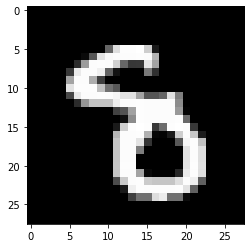

In [14]:
plt.imshow(data[50000][0], cmap = plt.cm.gray, clim=(0, 255))

In [15]:
# Normalization parameters, computed on all data (train+test)
data_float = data.to(torch.float)
mean_pixel = torch.mean(data_float)
std_pixel = torch.std(data_float)
print(f'mean_pixel={mean_pixel}, std_pixel={std_pixel}')

mean_pixel=33.38596725463867, std_pixel=78.65437316894531


In [16]:
print('data size=', data.size())
X = (data_float - mean_pixel) / std_pixel
print('X size=', X.size())
print(f'mean input={torch.mean(X)}, std input={torch.std(X)}')

data size= torch.Size([70000, 1, 28, 28])
X size= torch.Size([70000, 1, 28, 28])
mean input=-4.4450676028873204e-08, std input=1.0


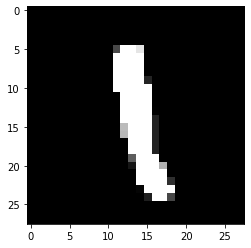

In [17]:
plt.imshow(X[7000][0], cmap = plt.cm.gray, clim=(0, 1))

### Prepare output vectors in "one hot encoding" format
`label` are the classes `(0, 1, ..., 9)`.

In [18]:
Y = torch.zeros([len(X), 10], dtype=torch.float)
for i in range(len(X)):
    Y[i][label[i]] = 1.

# example: 
Y[7000]

tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])

### Shuffle the examples
During learning, the examples should be presented in a random order. 
Because if we present all the examples from class 0, then class 1, etc., the learning would not converge.

In [19]:
# .randperm generates permutations:
torch.randperm(10)

tensor([8, 1, 0, 5, 7, 6, 3, 4, 2, 9])

In [20]:
# Shuffle the examples:
indices_permutes = torch.randperm(len(X))
X_perm = X[indices_permutes]
Y_perm = Y[indices_permutes]
print(X_perm.size())

torch.Size([70000, 1, 28, 28])


### Split the data in train/test sets:
In this case, we learn on 2/3 of the data, and use the remaining tier to estimate the performances.

In [21]:
n_train = (len(X)*2)//3
X_train = X_perm[:n_train]
Y_train = Y_perm[:n_train]

X_test = X_perm[n_train:]
Y_test = Y_perm[n_train:]
print('Learning on', len(X_train), 'examples')
print('Eval     on', len(X_test), 'examples')

Learning on 46666 examples
Eval     on 23334 examples


In [22]:
out = net(X_train[0:1])
print(out)

tensor([[0.5654, 0.5274, 0.4903, 0.4952, 0.3702, 0.5214, 0.5285, 0.4423, 0.5318,
         0.4969]], grad_fn=<SigmoidBackward>)


In [23]:
# The predicted class (0, 1, 2, ..., 9) is given by the index of the max:
torch.argmax(out)

tensor(0)

In [24]:
# Get classification errors
def idx_classif_errors(Y_true, Y_pred):
    """Number of classification errors, on 2 "one hot encoded" tensors
    """
    Y_pred_cls = np.argmax(Y_pred.detach().numpy(), axis=1)
    Y_true_cls = np.argmax(Y_true.detach().numpy(), axis=1)
    return np.where(Y_pred_cls != Y_true_cls)[0]

def nb_classif_errors(Y_true, Y_pred):
    return len(idx_classif_errors(Y_true, Y_pred))

# Let's try this on the first 1000 examples:
nb_err = nb_classif_errors( Y_train[:1000], net(X_train[:1000]) ) 
print("Number of errors:", nb_err, "(", nb_err*100/1000., "%)")

Number of errors: 887 ( 88.7 %)


# Learning the Network

In [25]:
optimizer = torch.optim.SGD(net.parameters(), lr=1.)
batch_size = 10
num_epochs = 36

losses = [] # record losses and error rates during learning
train_err_rates = []
test_err_rates = []

In [26]:
# Learning loop
for epoch in range(num_epochs):
    print("starting epoch", epoch)
    for beg_i in range(0, X_train.size(0), batch_size):
        x_batch = X_train[ beg_i:beg_i + batch_size, :]
        y_batch = Y_train[ beg_i:beg_i + batch_size]        
        # forward:
        outputs = net(x_batch)
        loss = criterion(outputs, y_batch)
        # reset gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.data.item())
        if (beg_i//batch_size) % 1000 == 0: 
            # print cost after 1000 updates (mini-batches):
            print(beg_i, 'loss=%3.3g' % losses[-1])
    
    # Measure error rate after each epoch
    train_nb_err = nb_classif_errors( Y_train, net(X_train) ) 
    train_err_rates.append( train_nb_err*100/len(Y_train) )
    test_nb_err = nb_classif_errors( Y_test, net(X_test) ) 
    test_err_rates.append( test_nb_err*100/len(Y_test) )
    print("Nb of errors (training set):", train_nb_err, "(%3.2g%%)" % train_err_rates[-1])
    print("Nb of errors (test set):", test_nb_err, "(%3.2g%%)" % test_err_rates[-1])


print("Done.")

starting epoch 0
0 loss=0.231
10000 loss=0.0106
20000 loss=0.021
30000 loss=0.00041
40000 loss=0.000132
Nb of errors (training set): 1674 (3.6%)
Nb of errors (test set): 1006 (4.3%)
starting epoch 1
0 loss=0.000726
10000 loss=0.00701
20000 loss=0.0131
30000 loss=0.000106
40000 loss=1.54e-05
Nb of errors (training set): 1200 (2.6%)
Nb of errors (test set): 877 (3.8%)
starting epoch 2
0 loss=0.000159
10000 loss=0.00444
20000 loss=0.00758
30000 loss=0.000114
40000 loss=7.17e-05
Nb of errors (training set): 977 (2.1%)
Nb of errors (test set): 770 (3.3%)
starting epoch 3
0 loss=3e-05
10000 loss=0.000776
20000 loss=0.00358
30000 loss=5.75e-05
40000 loss=4.4e-06
Nb of errors (training set): 843 (1.8%)
Nb of errors (test set): 723 (3.1%)
starting epoch 4
0 loss=5.65e-05
10000 loss=0.000176
20000 loss=0.00111
30000 loss=0.000156
40000 loss=1.88e-06
Nb of errors (training set): 729 (1.6%)
Nb of errors (test set): 714 (3.1%)
starting epoch 5
0 loss=0.000134
10000 loss=8.04e-05
20000 loss=0.000974

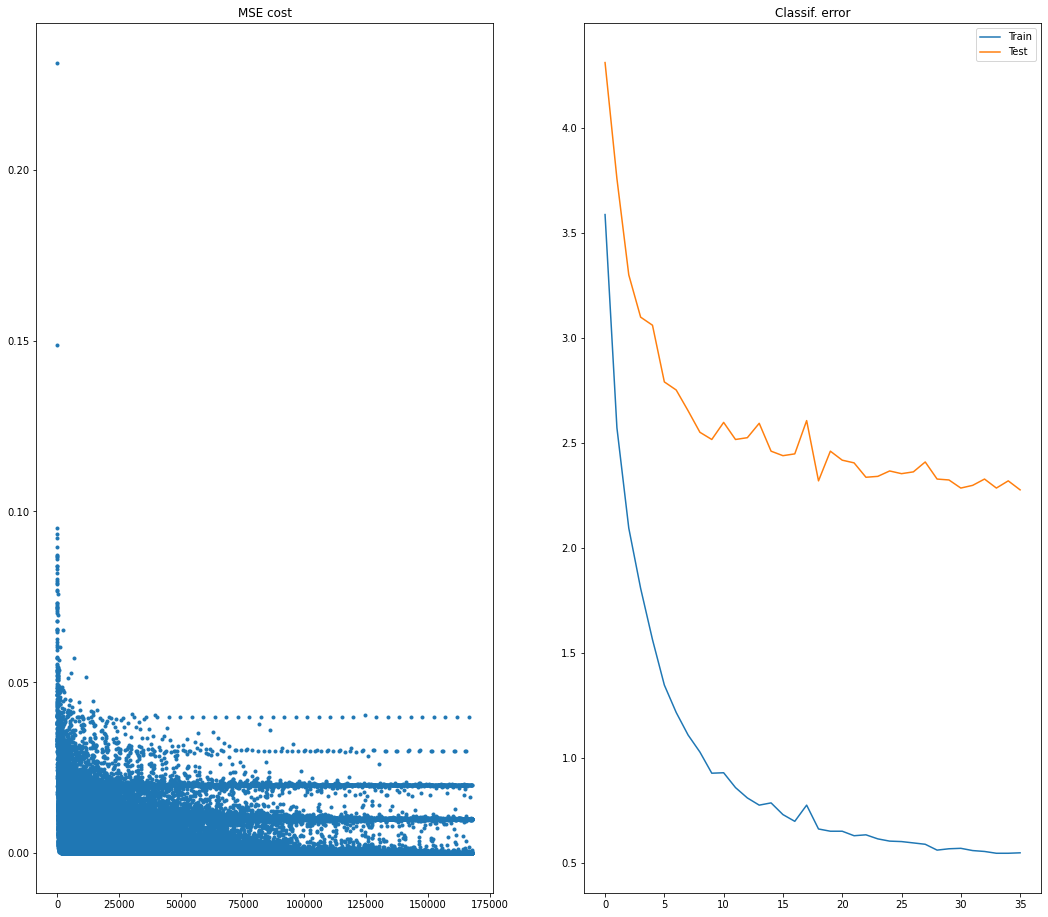

In [27]:
plt.figure(figsize=(18, 16))
plt.subplot(1,2,1)
plt.plot(losses, linestyle='', marker='.')
plt.title('MSE cost')
plt.subplot(1,2,2)
plt.plot(train_err_rates, label="Train")
plt.plot(test_err_rates, label="Test")
plt.title('Classif. error')
jnk=plt.legend()

## Display the 12 first errors on the testing set:

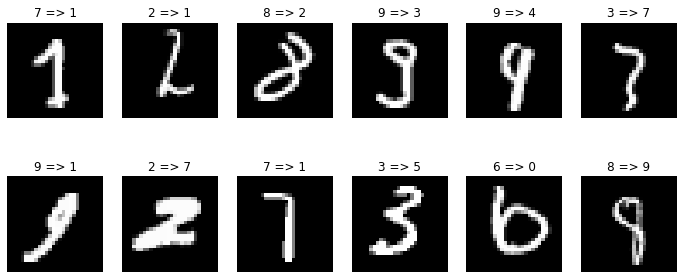

In [28]:
Y_pred = net(X_test)
test_errors_idx = idx_classif_errors( Y_test, Y_pred )[:12]

fig = plt.figure(figsize=(12,8))
ncols = 6
nrows = len(test_errors_idx) // ncols + 1
index = 1
for i in test_errors_idx:
    plt.subplot(nrows, ncols, index)
    plt.imshow( X_test[i].reshape(ImHeight,ImWidth), cmap=plt.cm.gray)
    plt.axis('off')
    true_class = torch.argmax(Y_test[i])
    pred_class = torch.argmax(Y_pred[i])
    plt.title(f'{true_class} => {pred_class}')
    index += 1

    

# Questions 

1. What does each point on the MSE (left) graph represent ?

2. Compute and print the confusion matrix on the training test and on the test set. What classes are confused with each other ?

3. Looking at the classification error curves (right), do you think the network is underfitting or overfitting ? What could we do to enhance generalization ? Make some experiments and discuss the results.


# Answers
1. Each point on the MSE graph represent for the loss of each batch data loader in the training phase (per one iteration).

3. According to the Error curves, I believe that the model is overfitting, because the value of the error in the training phase strongly decrease, at the same time the value of the error in the testing phase slightly fall. We have many solutions to handle this weakness, one of these is to decrease the number of hidden layers of the model, it seems that the model is too deep, but in this case, we have 2 hidden layers so the model is not deep. We have another approach is using the Dropout technique by turning off some nodes in the hidden layer according to a specific percentage. Besides, there has a cutting-edge technique is called Weight decay.

In [57]:
Y_train_hat = net(X_train)

In [94]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [95]:
accuracy_score(np.argmax(Y_train.numpy(), axis=1), np.argmax(Y_train_hat.data.numpy(), axis=1))

0.9945356362233746

In [96]:
accuracy_score(np.argmax(Y_test.numpy(), axis=1), np.argmax(Y_pred.data.numpy(), axis=1))

0.9772435073283621

In [90]:
def evaluate(y_gt, y_pred):
    cm = confusion_matrix(np.argmax(y_gt.numpy(), axis=1), np.argmax(y_pred.data.numpy(), axis=1))
    print(cm)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if i!= j:
                if cm[i][j] != 0:
                    print(f'The number of samples of class {i} is confused with class {j} is: {cm[i][j]} samples')


In [93]:
print('2.1 The confusion matrix on the training set')
print('='*55)
evaluate(Y_train, Y_train_hat)

2.1 The confusion matrix on the training set
[[4639    0    2    1    1    0    3    1    1    1]
 [   0 5236    9    2    4    1    0    1    1    0]
 [   4    2 4627    1    3    1    0    6    4    3]
 [   0    1   11 4702    2    6    0    8    5    8]
 [   3    0    0    0 4524    1    1    1    1    3]
 [   7    2    2    5    3 4184    8    1    4    6]
 [   4    2    1    0    1    3 4651    0    2    0]
 [   0    7   10    4    6    1    1 4766    0    3]
 [   4    5    3    7    4    4    5    1 4478    2]
 [   4    2    0    5    8    3    0    7    5 4604]]
The number of samples of class 0 is confused with class 2 is: 2 samples
The number of samples of class 0 is confused with class 3 is: 1 samples
The number of samples of class 0 is confused with class 4 is: 1 samples
The number of samples of class 0 is confused with class 6 is: 3 samples
The number of samples of class 0 is confused with class 7 is: 1 samples
The number of samples of class 0 is confused with class 8 is: 1 

In [92]:
print('2.2 The confusion matrix on the testing set')
print('='*55)
evaluate(Y_test, Y_pred)

2.2 The confusion matrix on the testing set
[[2224    0    2    0    2    5    9    1    7    4]
 [   0 2606    5    4    3    0    3    0    2    0]
 [   7    5 2273   19    6    3    3   10    9    4]
 [   2    3   15 2329    1   23    0    8   12    5]
 [   6    4    6    0 2249    0    5    5    1   14]
 [   2    3    5   17    1 2032   11    1   15    4]
 [   9    3    3    1    7   14 2171    0    4    0]
 [   1   11   11    2    9    4    0 2441    4   12]
 [   7    9    6   12    8   14   10    4 2230   12]
 [   4    4    0   12   26    8    4   11    3 2248]]
The number of samples of class 0 is confused with class 2 is: 2 samples
The number of samples of class 0 is confused with class 4 is: 2 samples
The number of samples of class 0 is confused with class 5 is: 5 samples
The number of samples of class 0 is confused with class 6 is: 9 samples
The number of samples of class 0 is confused with class 7 is: 1 samples
The number of samples of class 0 is confused with class 8 is: 7 s

In [151]:
from fastprogress.fastprogress import master_bar, progress_bar


def investigate_ovf(X_train, Y_train, X_test, Y_test, mas_bar, epochs = 36, p = 0.1):
    net = Net()
    optimizer = torch.optim.SGD(net.parameters(), lr=1e-2, weight_decay=1e-6)
    batch_size = 16
    losses = [] # record losses and error rates during learning
    train_err_rates = []
    test_err_rates = []
    # Learning loop
#     for epoch in progress_bar(range(epochs), parent = mas_bar):
    for epoch in progress_bar(range(epochs)):

#         print("starting epoch", epoch)
        for beg_i in range(0, X_train.size(0), batch_size):
            x_batch = X_train[ beg_i:beg_i + batch_size, :]
            y_batch = Y_train[ beg_i:beg_i + batch_size]        
            # forward:
            outputs = net(x_batch)
            loss = criterion(outputs, y_batch)
            # reset gradients
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.data.item())

        # Measure error rate after each epoch
        train_nb_err = nb_classif_errors( Y_train, net(X_train)) 
        train_err_rates.append( train_nb_err*100/len(Y_train))
        test_nb_err = nb_classif_errors( Y_test, net(X_test)) 
        test_err_rates.append( test_nb_err*100/len(Y_test) )
    
    return train_nb_err, train_err_rates, test_nb_err, test_err_rates, net

In [152]:
# mb = master_bar(np.arange(0.2,0.4,0.1))
# train_nb_errs = []
# train_err_rates = []
# test_nb_errs = []
# test_err_rates = []

# for p in mb:
#     train_nb_err, train_err, test_nb_err, test_err, net = investigate_ovf(
#                                         X_train, Y_train, X_test, Y_test, mb, epochs = 36, p = p)
    
#     train_nb_errs.append(train_nb_err)
#     train_err_rates.append(train_err)
#     test_nb_errs.append(test_nb_err)
#     test_err_rates.append(test_err)

In [153]:
# from matplotlib import gridspec
# fig = plt.figure(figsize=(18, 32))
# spec = gridspec.GridSpec(ncols=2, nrows=4, width_ratios=[1,1], height_ratios=[2,2,2,2])

# for i in range(len(train_err_rates)):
#     if i < 8:
#         ax = fig.add_subplot( spec[i] )    
#         ax.plot(train_err_rates[i], label="Train")
#         ax.plot(test_err_rates[i], label="Test")

I conducted with many dropout values but the result is quite bad, so I adopted the weight decay.

In [154]:
train_nb_err, train_err, test_nb_err, test_err, net = investigate_ovf(
                                        X_train, Y_train, X_test, Y_test, mb, epochs = 36)

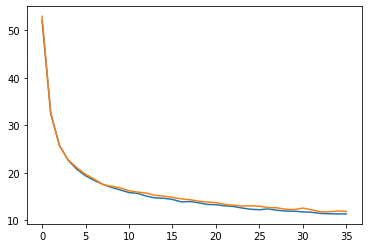

In [155]:
plt.plot(train_err)
plt.plot(test_err)